In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import argparse
import os
import cv2
import math
import keras
import matplotlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
from keras.layers import (Activation, Conv3D, MaxPooling3D, MaxPooling2D)


##

from keras.backend import set_session


In [ ]:
#matplotlib.use('AGG')
%matplotlib inline

In [ ]:
class Videoto3D:

    def __init__(self, width, height, depth):
        self.width = width
        self.height = height
        self.depth = depth

    def video3d(self, filename, color=False, skip=True):

        cap = cv2.VideoCapture(filename)

        nframe = cap.get(cv2.CAP_PROP_FRAME_COUNT)

        if skip:
            frames = [x * nframe / self.depth for x in range(self.depth)]
        else:
            frames = [x for x in range(self.depth)]

        framearray = []

        for i in range(self.depth):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i])
            ret, frame = cap.read()

            frame = cv2.resize(frame, (self.height, self.width))

            if color:
                framearray.append(frame)
            else:
                framearray.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

        cap.release()

        return np.array(framearray)

    def get_UCF_classname(self, filename):
        x =  filename[filename.find('_') + 1:filename.find('_', 2)]
        print(x)
        return x

In [ ]:
def plot_history(history, result_dir):
    plt.plot(history.history['accuracy'], marker='.')
    plt.plot(history.history['val_accuracy'], marker='.')
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.savefig(os.path.join(result_dir, 'model_accuracy.png'))
    plt.show()
    plt.close()

    plt.plot(history.history['loss'], marker='.')
    plt.plot(history.history['val_loss'], marker='.')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['loss', 'val_loss'], loc='upper right')
    plt.savefig(os.path.join(result_dir, 'model_loss.png'))
    plt.show()
    plt.close()


def save_history(history, result_dir):
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    nb_epoch = len(acc)

    with open(os.path.join(result_dir, 'result.txt'), 'w') as fp:
        fp.write('epoch\tloss\tacc\tval_loss\tval_acc\n')
        for i in range(nb_epoch):
            fp.write('{}\t{}\t{}\t{}\t{}\n'.format(
                i, loss[i], acc[i], val_loss[i], val_acc[i]))

In [ ]:
def loaddata(video_dir, vid3d, nclass, result_dir, color=False, skip=True):

    files = os.listdir(video_dir)
    X = []
    labels = []
    labellist = []

    pbar = tqdm(total=len(files))

    for filename in files:

        pbar.update(1)

        if filename == '.DS_Store':
            continue

        name = os.path.join(video_dir, filename)

        for v_files in os.listdir(name):

            v_file_path = os.path.join(name, v_files)

            label = vid3d.get_UCF_classname(filename)

            if label not in labellist:

                if len(labellist) >= nclass:
                    continue

                labellist.append(label)

            labels.append(label)

            X.append(vid3d.video3d(v_file_path, color=color, skip=skip))

    pbar.close()

    with open(os.path.join(result_dir, 'classes.txt'), 'w') as fp:
        for i in range(len(labellist)):
            fp.write('{}\n'.format(labellist[i]))

    for num, label in enumerate(labellist):
        for i in range(len(labels)):
            if label == labels[i]:
                labels[i] = num
    if color:
        return np.array(X).transpose((0, 2, 3, 4, 1)), labels
    else:
        return np.array(X).transpose((0, 2, 3, 1)), labels

In [ ]:
skip_arg = True
depth_args = 10
epoch_args = 100
batch_args = 128

In [ ]:
img_rows, img_cols, frames = 32, 32, 10
channel = 3

In [ ]:
vid3d = Videoto3D(img_rows, img_cols, frames)

In [ ]:
# Number of Classes for our model
nb_classes = 101

In [ ]:
# Save dataset as a numpy format
fname_npz = 'dataset_{}_{}_{}.npz'.format(
        nb_classes , depth_args, skip_arg)

In [ ]:
x, y = loaddata('/content/drive/MyDrive/Colab Notebooks/dataset', vid3d, nb_classes, '/content/drive/MyDrive/Colab Notebooks/input_df', 3, True)


In [ ]:
X = x.reshape((x.shape[0],img_rows, img_cols, frames, channel))
Y = np_utils.to_categorical(y, nb_classes)

X = X.astype('float32')
np.savez(fname_npz, X=X , Y=Y)
print('Saved dataset to dataset.npz.')
print('X_shape:{}\nY_shape:{}'.format(X.shape, Y.shape))

Saved dataset to dataset.npz.
X_shape:(13336, 32, 32, 10, 3)
Y_shape:(13336, 101)


In [ ]:
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same', input_shape=(X.shape[1:])))
model.add(Activation('relu'))
model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('softmax'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model.add(Dropout(0.25))
model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('softmax'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 32, 32, 10, 32)    2624      
                                                                 
 activation (Activation)     (None, 32, 32, 10, 32)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 32, 32, 10, 32)    27680     
                                                                 
 activation_1 (Activation)   (None, 32, 32, 10, 32)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 11, 11, 4, 32)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 4, 32)     0         
                                                        

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=43)

In [ ]:
# 1
# filepath : directory to save the model checkpoints (Checkpoints are saved as the format defined)
filepath="/content/drive/MyDrive/Colab Notebooks/results/d_3dcnnmodel-{epoch:02d}-{val_accuracy:.2f}.hd5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

In [ ]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size= batch_args,
                        epochs= epoch_args , verbose=1, shuffle=True, callbacks=callbacks_list)

model.evaluate(X_test, Y_test, verbose=0)

model_json = model.to_json()

Epoch 1/100
84/84 [==============================] - ETA: 0s - loss: 4.6858 - accuracy: 0.0168
Epoch 1: val_accuracy improved from -inf to 0.06372, saving model to /content/drive/MyDrive/Colab Notebooks/results/d_3dcnnmodel-01-0.06.hd5
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/results/d_3dcnnmodel-01-0.06.hd5/assets
84/84 [==============================] - 30s 202ms/step - loss: 4.6858 - accuracy: 0.0168 - val_loss: 4.3935 - val_accuracy: 0.0637
Epoch 2/100
84/84 [==============================] - ETA: 0s - loss: 4.1969 - accuracy: 0.0710
Epoch 2: val_accuracy improved from 0.06372 to 0.12369, saving model to /content/drive/MyDrive/Colab Notebooks/results/d_3dcnnmodel-02-0.12.hd5
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/results/d_3dcnnmodel-02-0.12.hd5/assets
84/84 [==============================] - 15s 178ms/step - loss: 4.1969 - accuracy: 0.0710 - val_loss: 3.8193 - val_accuracy: 0.1237
Epoch 3/100
84/84 [==============

In [ ]:
model.evaluate(X_test, Y_test, verbose=0)

[0.648360550403595, 0.8302099108695984]

In [ ]:
# path to the directory which results and final model is saved
outfile_path = '/content/drive/MyDrive/Colab Notebooks/results'

In [ ]:
with open(os.path.join(outfile_path, 'myfirst_3dcnnmodel.json'), 'w') as json_file:
        json_file.write(model_json)

In [ ]:
model.save_weights(os.path.join(outfile_path, 'myfirst_3dcnnmodel-gpu.hd5'))

loss, acc = model.evaluate(X_test, Y_test, verbose=0)

Test loss: 0.648360550403595
Test accuracy: 0.8302099108695984


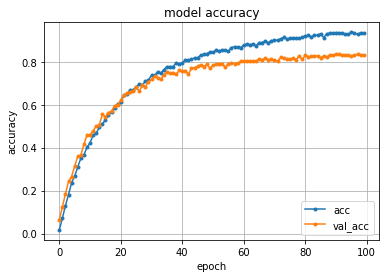

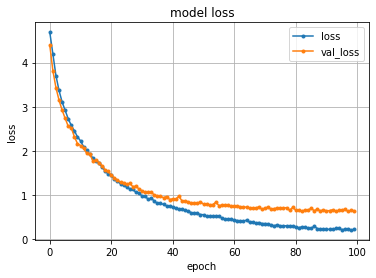

In [ ]:
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_history(history, outfile_path)
save_history(history, outfile_path)